<a href="https://colab.research.google.com/github/Atharvbillore/Med_Covid_Vision/blob/main/Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.67GB
Available: 11.48GB
Used: 916.34MB
Percentage: 9.4%


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [ ]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time

!pip install tensorflow
!pip install keras
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#The path of our data on drive
data_dir =  r'/gdrive/My Drive/X-Ray'

#Loading Data
data = load_files(data_dir)

In [ ]:
folders=os.listdir("/gdrive/My Drive/X-Ray")
print(folders)

['No_findings', 'Covid-19']


In [ ]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])

# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  /gdrive/My Drive/X-Ray/No_findings/00002550_000.png
Target labels -  1
Number of training files :  625
Number of training targets :  625


In [ ]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 150,150
    #Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           150*150 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)

        #update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape)
print('First training item : ',X[0])

(625, 150, 150, 3)
First training item :  [[[27. 27. 27.]
  [35. 35. 35.]
  [23. 23. 23.]
  ...
  [22. 22. 22.]
  [22. 22. 22.]
  [23. 23. 23.]]

 [[22. 22. 22.]
  [25. 25. 25.]
  [22. 22. 22.]
  ...
  [22. 22. 22.]
  [22. 22. 22.]
  [22. 22. 22.]]

 [[23. 23. 23.]
  [22. 22. 22.]
  [22. 22. 22.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [23. 23. 23.]]

 ...

 [[29. 29. 29.]
  [66. 66. 66.]
  [76. 76. 76.]
  ...
  [58. 58. 58.]
  [66. 66. 66.]
  [67. 67. 67.]]

 [[23. 23. 23.]
  [50. 50. 50.]
  [71. 71. 71.]
  ...
  [55. 55. 55.]
  [70. 70. 70.]
  [76. 76. 76.]]

 [[21. 21. 21.]
  [25. 25. 25.]
  [56. 56. 56.]
  ...
  [51. 51. 51.]
  [79. 79. 79.]
  [83. 83. 83.]]]


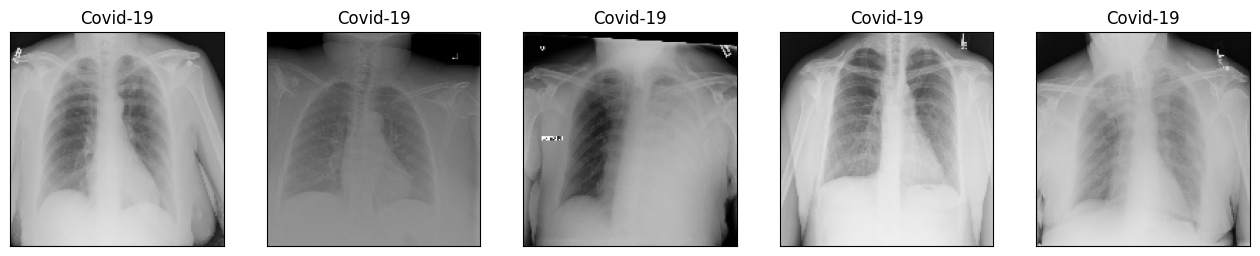

In [ ]:
#Let's look at first 5 training data.
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [ ]:
"""
   After that data is converted into Numpy array, Now,
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :)
no_of_classes = len(np.unique(y))
no_of_classes

2

In [ ]:
y

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,

In [ ]:
!pip install keras
"""
let's converts a class vector (integers) to binary class matrix by performing the
one-hot encoding on the labels
"""
y = np.array(keras.utils.to_categorical(y,no_of_classes))
y[0]

array([0., 1.])

In [ ]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])

X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  500
The validation Data Shape  63
The test Data Shape  62


In [ ]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (150, 150, 3)


In [ ]:
# Required libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=X_train.shape[1:], activation='relu', name='Conv2D_1'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv2D_2'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_1'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_3'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2D_4'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_2'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_5'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Conv2D_6'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_3'))

model.add(Flatten())
model.add(Dense(units=512, activation='relu', name='Dense_1'))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu', name='Dense_2'))
model.add(Dense(units=no_of_classes, activation='softmax', name='Output'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.optimizers import RMSprop

optimizer =RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose = 1, factor = 0.5, minlr = 0.00001)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Time to train our model!
epochs = 100
batch_size = 31

# Define data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size
)

validation_generator = test_datagen.flow(
    X_valid, y_valid,
    batch_size=batch_size
)

# Define callbacks
checkpointer = ModelCheckpoint("/gdrive/My Drive/NouredAminaArcht.keras", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=10, verbose=1)

# Start training
start = time.time()


history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    verbose=1,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_valid) // batch_size,
    callbacks=[checkpointer]  # Add learning_rate_reduction if defined
)

end = time.time()

duration = end - start
print(f'\nThis Model took {duration:0.2f} seconds ({duration/60:0.1f} minutes) to train for {epochs} epochs')

NameError: name 'ImageDataGenerator' is not defined

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(
     X_test, y_test, batch_size=batch_size, verbose=2)

print("Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Loss: {}".format(eval_loss))

2/2 - 1s - loss: 0.0892 - accuracy: 0.9677 - 1s/epoch - 560ms/step
Accuracy: 96.77%
Loss: 0.08915885537862778


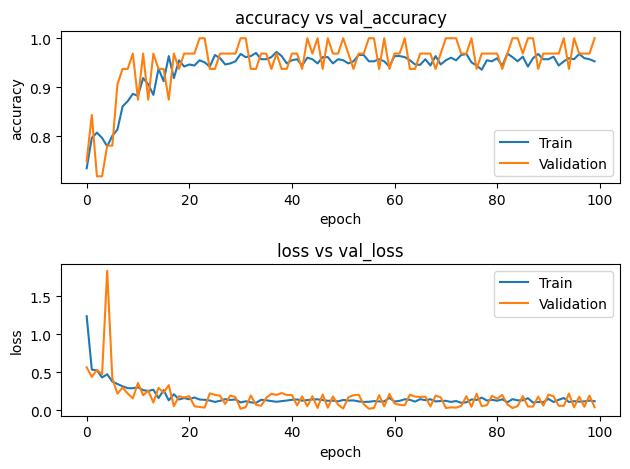

In [ ]:
# Let's visualize the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt
def plot(history):
    plt.figure(1)
     # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy vs val_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

     # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss vs val_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()

# Finaly, let's call the plot function with the 'result' parameter

plot(history)

2/2 [==============================] - 0s 23ms/step


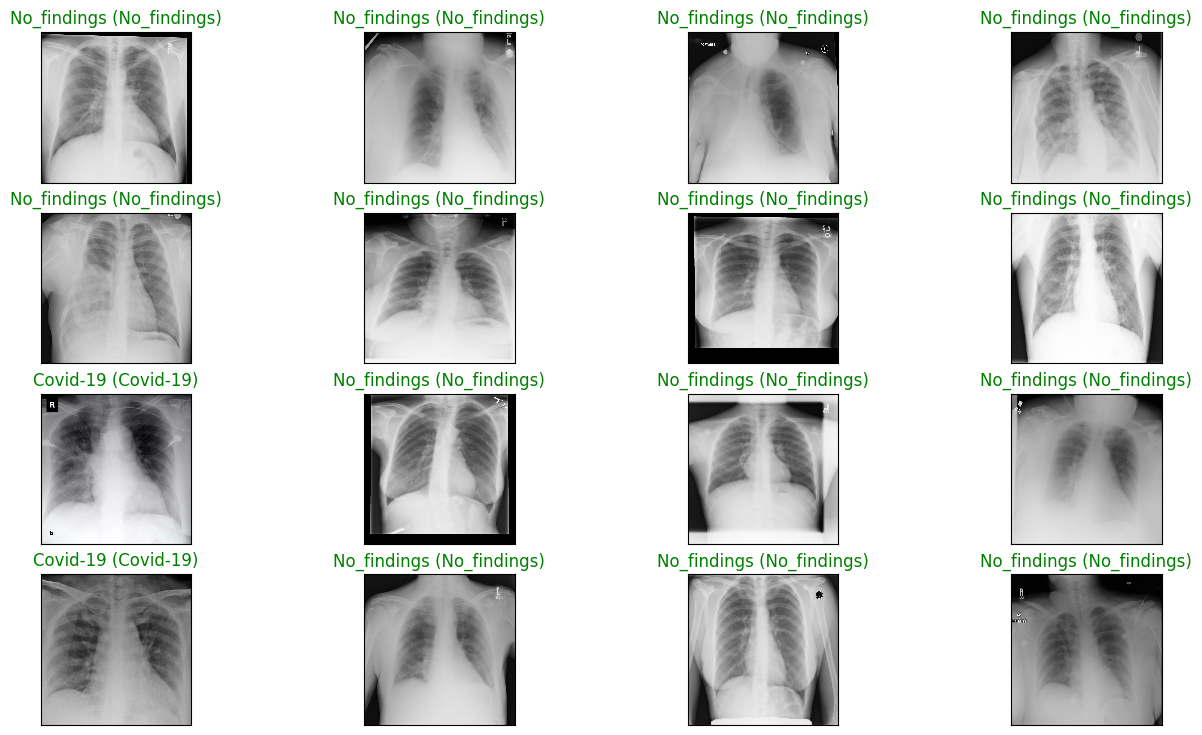

In [ ]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

2/2 [==============================] - 0s 21ms/step


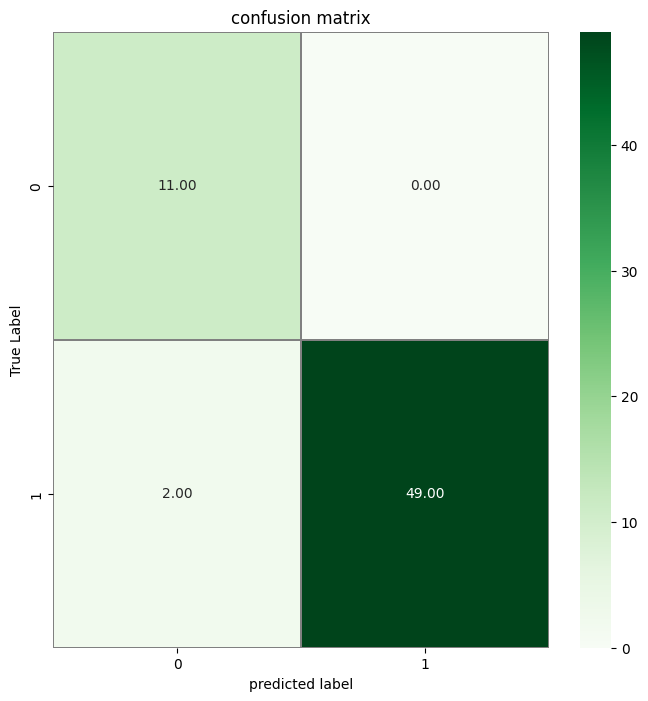

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [ ]:
my_model=keras.models.load_model("/gdrive/My Drive/NouredAminaArcht.h5")

2/2 [==============================] - 0s 21ms/step


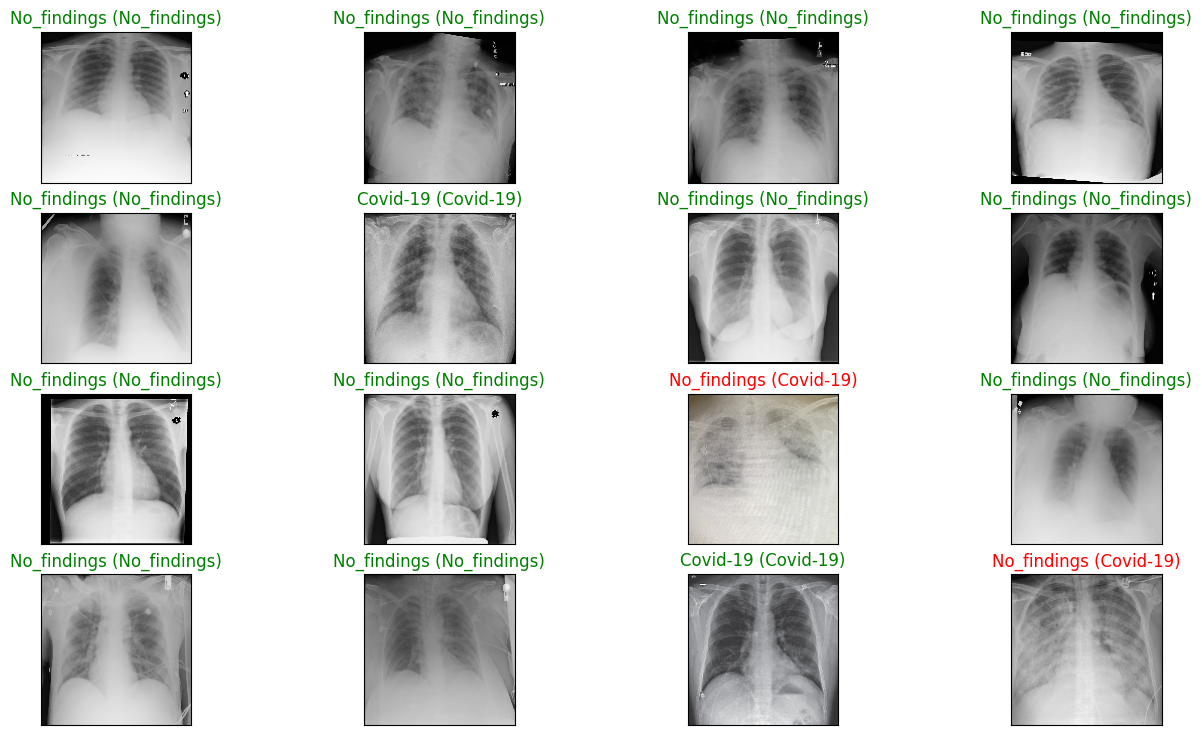

In [ ]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))

In [5]:
!git remote add origin https://github.com/Atharvbillore/MedVision.git


fatal: not a git repository (or any of the parent directories): .git


In [6]:
! git branch -M main

fatal: not a git repository (or any of the parent directories): .git
